#Стандардна семинарска по предметот Вовед во науката за податоци
Тема број 13 - Да се најдат податоците за цената на акциите и ESG score на компанијата Amazon за изминатите 4 години. Потоа, да се проучат податоците со користење на tsfresh и истите да се објаснат. Да се направи benchmark на најмалку 3 модели за предикција на цена на акциите на компанијата имајќи ги предвид горенаведените податоци. \

Изработил:\
Име и презиме: Теодор Петровски\
Индекс: 201128


Инсталирање на библиотеката tsfresh и импортирање на сите потребни библиотеки за целите на проектот

In [ ]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datetime import datetime as dt
import urllib.request
import json
from numpy import datetime64

from tsfresh import extract_features
import numpy as np
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

Превземање на датасетот кој ги содржи цените на акциите на Amazon во периодот од 01.08.2018 до 01.08.2022

In [ ]:
prices=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Seminarska/AMZN_Prices (2018-2022).csv')
prices.insert(0, 'ID', range(0, 0 + len(prices)))
prices.head()

,ID,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2018-08-01,89.199997,89.921997,88.801003,89.858498,89.858498,83062000
1,1,2018-08-02,89.438499,91.828003,89.300003,91.716499,91.716499,87094000
2,2,2018-08-03,91.887001,92.050003,91.074997,91.164497,91.164497,69210000
3,3,2018-08-06,91.290497,92.388496,90.945999,92.387497,92.387497,67836000
4,4,2018-08-07,92.726501,93.486000,92.313499,93.124001,93.124001,67550000


In [ ]:
prices.rename(columns={'Date': 'timestamp'}, inplace=True)


Ќе се фокусираме на предикција на High вредноста на акциите, за таа цел ги острануваме сите останати колони освен High i timestamp.

In [ ]:
prices.drop(['Open', 'Low','Close','Volume','Adj Close'], axis=1,inplace=True)

In [ ]:
missing_values_data = prices.isnull().sum()
percentage_data = 100 * prices.isnull().sum() / len(prices)
missing_values_table_data = pd.concat([missing_values_data, percentage_data], axis=1)
missing_values_table_data.columns = ['Num. of missing values','% of missing values']
missing_values_table_data


,Num. of missing values,% of missing values
ID,0,0.0
timestamp,0,0.0
High,0,0.0


Превземање на датасетот кој ги содржи месечните ESG scores за Amazon во периодот од 08.2018 до 08.2022  

In [ ]:

dataframes = []
url = "https://query2.finance.yahoo.com/v1/finance/esgChart?symbol=AMZN"

connection = urllib.request.urlopen(url)

data = connection.read()
data_2 = json.loads(data)
esg = data_2["esgChart"]["result"][0]["symbolSeries"]
esg = pd.DataFrame(esg)
esg["timestamp"] = pd.to_datetime(esg["timestamp"], unit="s")

In [ ]:
esg = esg[esg['timestamp'] >= '2018-08-01']


In [ ]:
esg.drop(['governanceScore', 'environmentScore','socialScore'], axis=1,inplace=True)

In [ ]:
print(esg)

    timestamp  esgScore
47 2018-08-01     45.21
48 2018-09-01     45.21
49 2018-10-01     44.82
50 2018-11-01     45.02
51 2018-12-01     45.02
52 2019-01-01     45.02
53 2019-02-01     45.02
54 2019-03-01     45.17
55 2019-04-01     45.17
56 2019-05-01     45.17
57 2019-06-01     44.87
58 2019-07-01     44.83
59 2019-08-01     44.83
60 2019-09-01     44.83
61 2019-10-01     44.83
62 2019-11-01     49.57
63 2019-12-01     30.57
64 2020-01-01     30.57
65 2020-02-01     30.57
66 2020-03-01     30.57
67 2020-04-01       NaN
68 2020-05-01       NaN
69 2020-06-01       NaN
70 2020-07-01     30.57
71 2020-08-01     30.33
72 2020-09-01       NaN
73 2020-10-01     27.42
74 2020-11-01       NaN
75 2020-12-01       NaN
76 2021-01-01     27.42
77 2021-02-01     27.42
78 2021-03-01     27.42
79 2021-04-01       NaN
80 2021-05-01     27.28
81 2021-06-01       NaN
82 2021-07-01       NaN
83 2021-08-01       NaN
84 2021-09-01     30.93
85 2021-10-01       NaN
86 2021-11-01       NaN
87 2021-12-01   

In [ ]:

missing_values_data = esg.isnull().sum()
percentage_data = 100 * esg.isnull().sum() / len(esg)
missing_values_table_data = pd.concat([missing_values_data, percentage_data], axis=1)
missing_values_table_data.columns = ['Num. of missing values','% of missing values']
missing_values_table_data


,Num. of missing values,% of missing values
timestamp,0,0.000000
esgScore,18,36.734694


In [ ]:
esg.fillna(method='bfill',inplace=True)

In [ ]:

missing_values_data = esg.isnull().sum()
percentage_data = 100 * esg.isnull().sum() / len(esg)
missing_values_table_data = pd.concat([missing_values_data, percentage_data], axis=1)
missing_values_table_data.columns = ['Num. of missing values','% of missing values']
missing_values_table_data


,Num. of missing values,% of missing values
timestamp,0,0.0
esgScore,0,0.0


Го менуваме типот на колоната со цел успешно да ја споиме со esg датасетот

In [ ]:

prices['timestamp']=prices['timestamp'].astype(datetime64)


In [ ]:
data=pd.merge(prices, esg, on='timestamp', how='outer')

In [ ]:
data

,ID,timestamp,High,esgScore
0,0.0,2018-08-01,89.921997,45.21
1,1.0,2018-08-02,91.828003,NaN
2,2.0,2018-08-03,92.050003,NaN
3,3.0,2018-08-06,92.388496,NaN
4,4.0,2018-08-07,93.486000,NaN
...,...,...,...,...
1018,NaN,2021-05-01,NaN,27.28
1019,NaN,2021-08-01,NaN,30.93
1020,NaN,2022-01-01,NaN,30.03
1021,NaN,2022-05-01,NaN,30.23


Правиме ffill на esgScore колоната бидејќи ESG score е ажуриран на месечно ниво, ќе претпоставиме дека за еден месец вредноста на ESG score не се менува.

In [ ]:

data['esgScore'] = data['esgScore'].ffill()

Ги елиминираме редовите кои содржат NaN вредност за колоната High, поради тоа што за викенди нема податоци за цени на акции

In [ ]:

data = data.dropna(subset=['High'])

In [ ]:
missing_values_data = data.isnull().sum()
percentage_data = 100 * data.isnull().sum() / len(data)
missing_values_table_data = pd.concat([missing_values_data, percentage_data], axis=1)
missing_values_table_data.columns = ['Num. of missing values','% of missing values']
missing_values_table_data

,Num. of missing values,% of missing values
ID,0,0.0
timestamp,0,0.0
High,0,0.0
esgScore,0,0.0


#Анализа на датасетот со помош на библиотеката tsfresh

In [ ]:
tsfresh_data=data.drop(['ID'], axis=1)
tsfresh_data['Symbol']='AMZN'

In [ ]:
tsfresh_data.head()

,timestamp,High,esgScore,Symbol
0,2018-08-01,89.921997,45.21,AMZN
1,2018-08-02,91.828003,45.21,AMZN
2,2018-08-03,92.050003,45.21,AMZN
3,2018-08-06,92.388496,45.21,AMZN
4,2018-08-07,93.486000,45.21,AMZN


In [ ]:


extracted_features=extract_features(timeseries_container=tsfresh_data,column_id="Symbol",column_sort="timestamp",n_jobs=8)

Feature Extraction: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]


In [ ]:
extracted_features

,High__variance_larger_than_standard_deviation,High__has_duplicate_max,High__has_duplicate_min,High__has_duplicate,High__sum_values,High__abs_energy,High__mean_abs_change,High__mean_change,High__mean_second_derivative_central,High__median,...,esgScore__fourier_entropy__bins_5,esgScore__fourier_entropy__bins_10,esgScore__fourier_entropy__bins_100,esgScore__permutation_entropy__dimension_3__tau_1,esgScore__permutation_entropy__dimension_4__tau_1,esgScore__permutation_entropy__dimension_5__tau_1,esgScore__permutation_entropy__dimension_6__tau_1,esgScore__permutation_entropy__dimension_7__tau_1,esgScore__query_similarity_count__query_None__threshold_0.0,esgScore__mean_n_absolute_max__number_of_maxima_7
AMZN,1.0,0.0,0.0,1.0,129138.11557,1.783638e+07,1.707524,0.047491,0.006426,123.486252,...,0.125256,0.136002,0.425614,0.073076,0.10965,0.14625,0.182873,0.21952,NaN,49.57


In [ ]:

print("Descriptive Statistics:")
pd.set_option('display.max_rows', 1600)
extracted_features.transpose()

Descriptive Statistics:


,AMZN
High__variance_larger_than_standard_deviation,1.000000e+00
High__has_duplicate_max,0.000000e+00
High__has_duplicate_min,0.000000e+00
High__has_duplicate,1.000000e+00
High__sum_values,1.291381e+05
High__abs_energy,1.783638e+07
High__mean_abs_change,1.707524e+00
High__mean_change,4.749054e-02
High__mean_second_derivative_central,6.426291e-03
High__median,1.234863e+02


Descriptive Statistics:
              High     esgScore
count  1006.000000  1006.000000
mean    128.367908    36.404543
std      35.396645     8.396548
min      69.801498    27.280000
25%      92.893125    30.030000
50%     123.486252    30.930000
75%     162.888756    45.020000
max     188.654007    49.570000


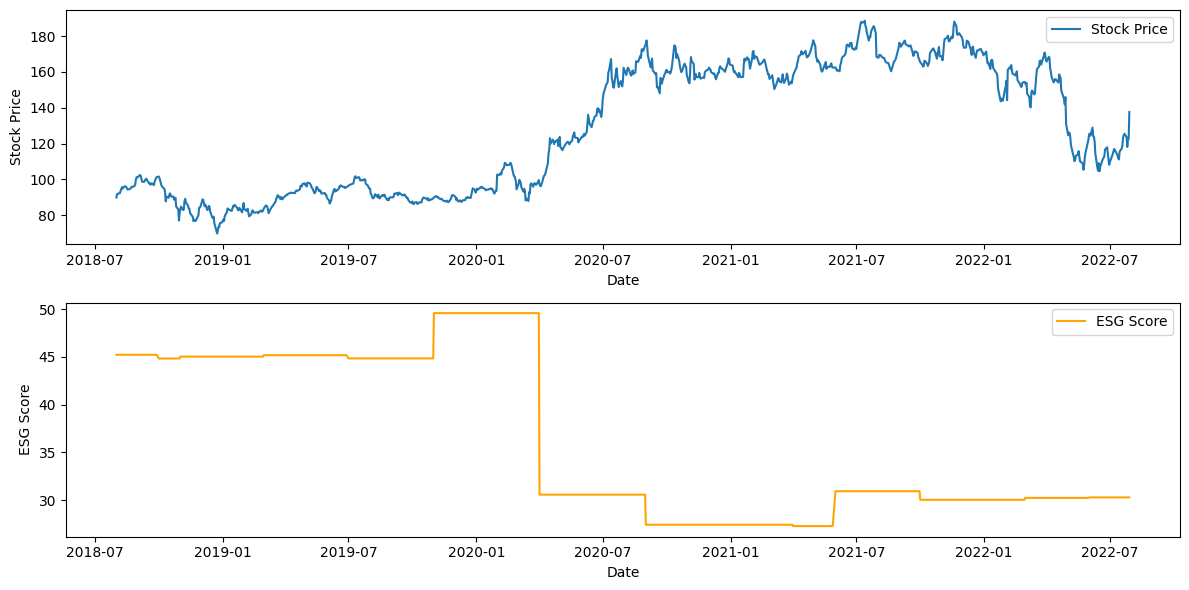

In [ ]:
print("Descriptive Statistics:")
print(tsfresh_data[['High', 'esgScore']].describe())

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tsfresh_data['timestamp'], tsfresh_data['High'], label='Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tsfresh_data['timestamp'], tsfresh_data['esgScore'], color='orange', label='ESG Score')
plt.xlabel('Date')
plt.ylabel('ESG Score')
plt.legend()

plt.tight_layout()
plt.show()

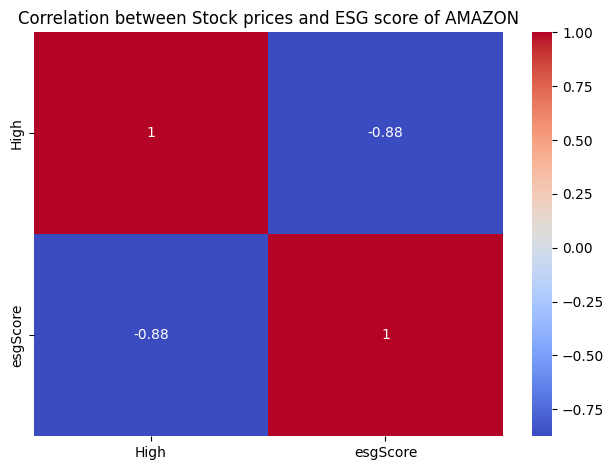

In [ ]:
correlation_matrix = tsfresh_data[['High', 'esgScore']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Stock prices and ESG score of AMAZON')
plt.tight_layout()
plt.show()

#Тренирање и тестирање на три модели за предикција на цените на акциите

Датасетот кој ќе биде користен за тренирање и  тестирање на моделите, дополнително ќе содржи колони на цените за претходните 3 дена.

In [ ]:

matrix = []
for i in range(len(data['High'])-1, 2, -1):

  day3=data['High'][i-3]
  day2=data['High'][i-2]
  day1=data['High'][i-1]
  matrix.append([data['High'][i], day1, day2, day3,data['esgScore'][i]])

matrix

[[137.649994, 122.839996, 121.900002, 118.150002, 30.28],
 [122.839996, 121.900002, 118.150002, 123.639999, 30.28],
 [121.900002, 118.150002, 123.639999, 125.5, 30.28],
 [118.150002, 123.639999, 125.5, 124.849998, 30.28],
 [123.639999, 125.5, 124.849998, 123.480003, 30.28],
 [125.5, 124.849998, 123.480003, 118.949997, 30.28],
 [124.849998, 123.480003, 118.949997, 117.239998, 30.28],
 [123.480003, 118.949997, 117.239998, 115.589996, 30.28],
 [118.949997, 117.239998, 115.589996, 111.18, 30.28],
 [117.239998, 115.589996, 111.18, 111.779999, 30.28],
 [115.589996, 111.18, 111.779999, 113.230003, 30.28],
 [111.18, 111.779999, 113.230003, 114.300003, 30.28],
 [111.779999, 113.230003, 114.300003, 116.580002, 30.28],
 [113.230003, 114.300003, 116.580002, 116.989998, 30.28],
 [114.300003, 116.580002, 116.989998, 115.480003, 30.28],
 [116.580002, 116.989998, 115.480003, 114.080002, 30.28],
 [116.989998, 115.480003, 114.080002, 109.75, 30.28],
 [115.480003, 114.080002, 109.75, 108.18, 30.28],
 [11

In [ ]:
df = pd.DataFrame(matrix,columns=['High','One day ago','Two days ago','Three days ago','esgScore'])
df.head()

,High,One day ago,Two days ago,Three days ago,esgScore
0,137.649994,122.839996,121.900002,118.150002,30.28
1,122.839996,121.900002,118.150002,123.639999,30.28
2,121.900002,118.150002,123.639999,125.500000,30.28
3,118.150002,123.639999,125.500000,124.849998,30.28
4,123.639999,125.500000,124.849998,123.480003,30.28


Модел за предикција број 1.\
Neural Network-LSTM

In [ ]:


scaler = StandardScaler()


test = df[:int(len(df)*0.2)]
train = df[int(len(df)*0.2):]


X_train = train.iloc[:,1:]
X_test = test.iloc[:,1:]

Y_train = train['High']
Y_test = test['High']

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(803, 4)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

(803, 1, 4)

In [ ]:

model = Sequential()

model.add(LSTM(150, input_shape=(1,4), activation='relu', return_sequences=True))

model.add(LSTM(96, activation='relu'))

model.add(Dense(1 ,activation='linear'))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
history = model.fit(X_train, Y_train, shuffle=False, validation_split=0.2, epochs=250, batch_size=12)

Epoch 1/250
54/54 [==============================] - 7s 31ms/step - loss: 18672.8418 - mean_absolute_error: 132.2065 - val_loss: 7686.1865 - val_mean_absolute_error: 87.3463
Epoch 2/250
54/54 [==============================] - 1s 21ms/step - loss: 18264.2637 - mean_absolute_error: 130.6656 - val_loss: 7036.9102 - val_mean_absolute_error: 83.4664
Epoch 3/250
54/54 [==============================] - 1s 21ms/step - loss: 12722.7920 - mean_absolute_error: 108.4496 - val_loss: 2555.8765 - val_mean_absolute_error: 47.8837
Epoch 4/250
54/54 [==============================] - 1s 22ms/step - loss: 1950.1466 - mean_absolute_error: 36.6887 - val_loss: 852.7023 - val_mean_absolute_error: 25.8433
Epoch 5/250
54/54 [==============================] - 1s 20ms/step - loss: 1546.4065 - mean_absolute_error: 29.3890 - val_loss: 914.9326 - val_mean_absolute_error: 26.7156
Epoch 6/250
54/54 [==============================] - 1s 20ms/step - loss: 936.0684 - mean_absolute_error: 21.5697 - val_loss: 927.2808 -

In [ ]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [ ]:
print("Mean Absolute Error : " + str(mean_absolute_error(y_pred, Y_test)))
print("Mean Squared Error : " + str(mean_squared_error(y_pred, Y_test)))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("R2 Score : " + str(r2_score(y_pred,Y_test)))

Mean Absolute Error : 6.990198307722168
Mean Squared Error : 64.56816197159476
Root Mean Squared Error : 8.035431660564027
R2 Score : 0.8564785073001234


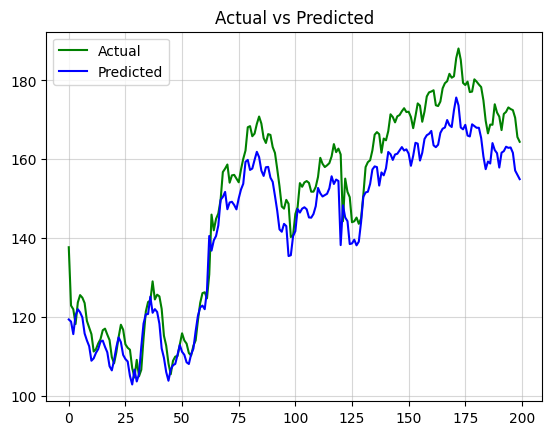

In [ ]:
plt.plot(Y_test, color = 'green', label = 'Actual')
plt.plot(y_pred, color = 'blue', label = 'Predicted')

plt.grid(alpha=0.5)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

Модел за предикција број 2.\
XGBoost

In [ ]:
scaler = StandardScaler()


test = df[:int(len(df)*0.2)]
train = df[int(len(df)*0.2):]


X_train = train.iloc[:,1:]
X_test = test.iloc[:,1:]

Y_train = train['High']
Y_test = test['High']

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:


model = XGBRegressor(objective ='reg:linear',colsample_bytree=0.8,learning_rate=0.2,max_depth=5,alpha=1,n_estimators=80)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)


[15:04:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:


print("Mean Absolute Error : " + str(mean_absolute_error(y_pred, Y_test)))
print("Mean Squared Error : " + str(mean_squared_error(y_pred, Y_test)))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("R2 Score : " + str(r2_score(y_pred,Y_test)))

Mean Absolute Error : 3.593071130571289
Mean Squared Error : 22.677025964437597
Root Mean Squared Error : 4.762040105294956
R2 Score : 0.9574440481677093


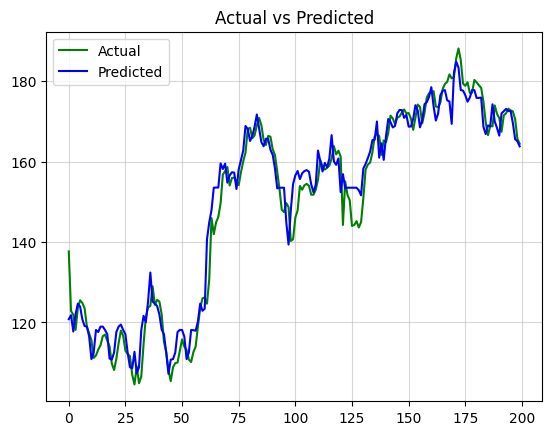

In [ ]:
plt.plot(Y_test, color = 'green', label = 'Actual')
plt.plot(y_pred, color = 'blue', label = 'Predicted')

plt.grid(alpha=0.5)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

Модел за предикција број 3.\
LGBM

In [ ]:
scaler = StandardScaler()


test = df[:int(len(df)*0.2)]
train = df[int(len(df)*0.2):]


X_train = train.iloc[:,1:]
X_test = test.iloc[:,1:]

Y_train = train['High']
Y_test = test['High']

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

LGBM = LGBMRegressor(n_estimators = 28,learning_rate=0.1,max_depth=3,min_child_samples=20,num_leaves=31)
LGBM.fit(X_train,Y_train)

y_pred = LGBM.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 4
[LightGBM] [Info] Start training from score 123.346105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
print("Mean Absolute Error : " + str(mean_absolute_error(y_pred, Y_test)))
print("Mean Squared Error : " + str(mean_squared_error(y_pred, Y_test)))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("R2 Score : " + str(r2_score(y_pred,Y_test)))

Mean Absolute Error : 3.3978620421278007
Mean Squared Error : 19.25172784020758
Root Mean Squared Error : 4.387679094943884
R2 Score : 0.9617924087307506


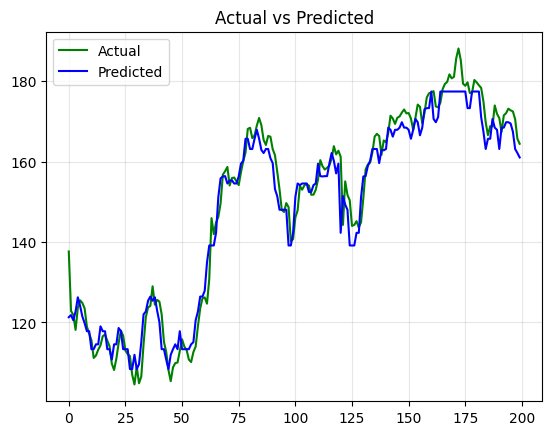

In [ ]:
plt.plot(Y_test, color = 'green', label = 'Actual')
plt.plot(y_pred, color = 'blue', label = 'Predicted')

plt.grid(alpha=0.3)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()